In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
file_path = "/kaggle/input/external-dataset-without-other-json/external_dataset_without_other.json"

In [ ]:
#function to pad the list to max length of all possible pii and non pii words
def pad(l, size, padding):
  return l + [padding] * abs((len(l)-size))

In [ ]:
train_data = pd.read_json(file_path, lines = True)

In [ ]:
#create the list of PIIs and the top N number of occurences of non-pii words
all_piis = []
top_non_pii = []
for iter in train_data.iloc():
  for idx, label in enumerate(iter['bio_labels']):
    if label != "O":
      all_piis.append(iter['tokenised_text'][idx].lower())
    else:
      top_non_pii.append(iter['tokenised_text'][idx].lower())

In [ ]:
#find the max length of chars across all words
temp = max(len(iter) for iter in all_piis)
max_len = max(len(iter) for iter in top_non_pii)
max_len = max(max_len, temp)

In [ ]:
#creating a map of all the characters in the words to assign a unique index
combined_data = '#'
for iter in all_piis:
  combined_data += iter
for iter in top_non_pii:
  combined_data += iter
#example for set() --> set("alan") -> (a,l,n)
chars = sorted(list(set(combined_data)))
mapping = dict((c, i) for i, c in enumerate(chars))

In [ ]:
#For debugging purposes
#Creating an index to char map

index_to_char = {v: k for k, v in mapping.items()}

In [ ]:
#convert characters to number mapping
for idx,iter in enumerate(all_piis):
  all_piis[idx] = [mapping[char] for char in iter]

#pad the strings to the maxlength
for idx,iter in enumerate(all_piis):
  all_piis[idx] = pad(iter,max_len,mapping['#'])

all_piis = pd.DataFrame(all_piis)

In [ ]:
#convert characters to number mapping
for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = [mapping[char] for char in iter]

#pad the strings to the maxlength
for idx,iter in enumerate(top_non_pii):
  top_non_pii[idx] = pad(iter,max_len,mapping['#'])

top_non_pii = pd.DataFrame(top_non_pii)

In [ ]:
#creating the labels
top_non_pii['label'] = [0]*len(top_non_pii)
all_piis['label'] = [1]*len(all_piis)

In [ ]:
#combine the pii words and non-pii words to create a master dataset
data = pd.concat([all_piis,top_non_pii], ignore_index=True)
data.reset_index()
#create X and Y dataset
x = data[data.columns.difference(['label'])]
y = data['label']

In [ ]:
from operator import index
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import torch
import keras


2024-04-21 00:38:57.393605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 00:38:57.393704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 00:38:57.659197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(480, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='leaky_relu'))
    model.add(Dense(256, activation='leaky_relu'))
    model.add(Dense(480, activation='leaky_relu'))
    model.add(Dense(512, activation='leaky_relu'))
    model.add(Dense(480, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import KFold

n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []
max_acc = 0
iteration_number = 1
best_iter = 0

# Iterate over folds

for train_index, val_index in kf.split(x):

    X_train, X_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Create and compile the model
    model = create_model()

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=64)

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    accuracies.append(accuracy)
    if(accuracy > max_acc):
        max_acc = accuracy
        file_name = f"/kaggle/working/NeuralNetModel_20_04_2_{iteration_number}.h5"
        model.save(file_name)
        best_iter = iteration_number
    iteration_number = iteration_number + 1

# Calculate and print the average accuracy
avg_accuracy = np.mean(accuracies)
print("Average Accuracy:", avg_accuracy)

Epoch 1/20
   57/13812 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7522 - loss: 0.5099  

I0000 00:00:1713659968.908338      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713659968.924999      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13812/13812 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9579 - loss: 0.1391
Epoch 2/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9684 - loss: 0.1062
Epoch 3/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9712 - loss: 0.0938
Epoch 4/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9733 - loss: 0.0837
Epoch 5/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9761 - loss: 0.0743
Epoch 6/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9780 - loss: 0.0678
Epoch 7/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9801 - loss: 0.0609
Epoch 8/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9813 - loss: 0.0563
Epoch 9/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9828 - loss: 0.0519
Epoch 10/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9839 - loss: 0.0488
Epoch 11/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9852 - loss: 0.0455
Epoch 12

W0000 00:00:1713660787.108949      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13812/13812 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9597 - loss: 0.1360
Epoch 2/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9685 - loss: 0.1052
Epoch 3/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9715 - loss: 0.0921
Epoch 4/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9743 - loss: 0.0811
Epoch 5/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9761 - loss: 0.0732
Epoch 6/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9786 - loss: 0.0656
Epoch 7/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9810 - loss: 0.0580
Epoch 8/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9824 - loss: 0.0538
Epoch 9/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9840 - loss: 0.0486
Epoch 10/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9850 - loss: 0.0457
Epoch 11/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9860 - loss: 0.0426
Epoch 12

W0000 00:00:1713661608.009169      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13812/13812 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9590 - loss: 0.1373
Epoch 2/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9687 - loss: 0.1049
Epoch 3/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9721 - loss: 0.0904
Epoch 4/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9740 - loss: 0.0810
Epoch 5/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9769 - loss: 0.0713
Epoch 6/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9789 - loss: 0.0643
Epoch 7/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9802 - loss: 0.0592
Epoch 8/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9823 - loss: 0.0534
Epoch 9/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9835 - loss: 0.0499
Epoch 10/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9845 - loss: 0.0466
Epoch 11/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9860 - loss: 0.0425
Epoch 12

W0000 00:00:1713662447.459784      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13812/13812 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9591 - loss: 0.1370
Epoch 2/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9683 - loss: 0.1065
Epoch 3/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9711 - loss: 0.0940
Epoch 4/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9736 - loss: 0.0824
Epoch 5/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9757 - loss: 0.0744
Epoch 6/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9782 - loss: 0.0668
Epoch 7/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9803 - loss: 0.0600
Epoch 8/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9819 - loss: 0.0547
Epoch 9/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9832 - loss: 0.0506
Epoch 10/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9845 - loss: 0.0467
Epoch 11/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9857 - loss: 0.0434
Epoch 12

W0000 00:00:1713663274.057956      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13812/13812 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9591 - loss: 0.1367
Epoch 2/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9685 - loss: 0.1046
Epoch 3/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9716 - loss: 0.0922
Epoch 4/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9741 - loss: 0.0818
Epoch 5/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9765 - loss: 0.0724
Epoch 6/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9788 - loss: 0.0651
Epoch 7/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9809 - loss: 0.0586
Epoch 8/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9825 - loss: 0.0536
Epoch 9/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9836 - loss: 0.0496
Epoch 10/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9845 - loss: 0.0464
Epoch 11/20
13812/13812 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9861 - loss: 0.0430
Epoch 12

In [ ]:
print(best_iter)

5


In [ ]:
#Loading the model
from tensorflow.keras.models import load_model
model_path = f"/kaggle/working/NeuralNetModel_20_04_2_{best_iter}.h5"
model = load_model(model_path)
y_pred_nn = model.predict(x_test)
correct = 0
tot = 0
for idx,iter in enumerate(y_pred_nn):
  tot += 1
  if y_pred_nn[idx][0] > y_pred_nn[idx][1]:
    if (y_test.iloc[idx] == 0):
      correct +=1
  else:
    if (y_test.iloc[idx] == 1):
      correct +=1
acc = correct/tot

6906/6906 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [ ]:
acc

0.9914924427550005

In [ ]:
count = 0
for idx,iter in enumerate(y_pred_nn):
  if y_test.iloc[idx] == 1 and iter[0] <= iter[1]:
    count+=1

count * 100 / y_test.sum()

93.19393406138398

In [ ]:
model.save('/kaggle/working/NeuralNetModel_20_04_2_Final.h5')

In [ ]:
#True Positives
count = 0
for idx,iter in enumerate(y_pred_nn):
  if y_test.iloc[idx] == 1 and iter[0] <= iter[1]:
    count+=1

TP = count
print(TP)

18006


In [ ]:
#True Negatives
count = 0
for idx,iter in enumerate(y_pred_nn):
  if y_test.iloc[idx] == 0 and iter[0] >= iter[1]:
    count+=1

TN = count
print(TN)

201094


In [ ]:
#False Negatives
count = 0
for idx,iter in enumerate(y_pred_nn):
  if y_test.iloc[idx] == 1 and iter[0] >= iter[1]:
    count+=1

FN = count
print(FN)

1315


In [ ]:
#False Positives
count = 0
for idx,iter in enumerate(y_pred_nn):
  if y_test.iloc[idx] == 0 and iter[0] <= iter[1]:
    count+=1

FP = count
print(FP)

565


In [ ]:
y_pred_actual = []
for idx,iter in enumerate(y_pred_nn):
  if iter[0] <= iter[1]:
    y_pred_actual.append(1)
  else:
    y_pred_actual.append(0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_actual)
print("Accuracy:", accuracy)
print("By hand Accuracy :", (TP+TN)/(TP+TN+FP+FN))


precision = precision_score(y_test, y_pred_actual)
print("Precision:", precision)
print("By hand Precision :", (TP)/(TP+FP))

recall = recall_score(y_test, y_pred_actual)
print("Recall:", recall)
print("By hand Recall :", (TP)/(TP+FN))

f1 = f1_score(y_test, y_pred_actual)
print("F1-score:", f1)
print("By hand F1-score :", (2*TP)/(2*TP+FN+FP))


Accuracy: 0.9914924427550005
By hand Accuracy : 0.9914924427550005
Precision: 0.9695762209897152
By hand Precision : 0.9695762209897152
Recall: 0.9319393406138399
By hand Recall : 0.9319393406138399
F1-score: 0.9503853056054049
By hand F1-score : 0.9503853056054048


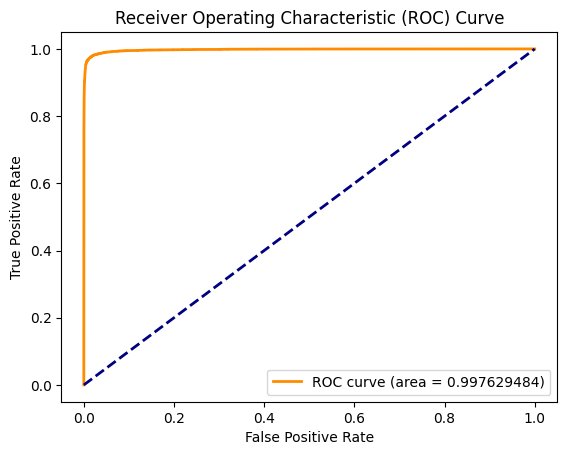

In [ ]:
###      ROC CURVE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = y_pred_nn[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.9f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# print("FPR" ,fpr)
# print("FPR By Hand" ,FP/(FP+TN))
# print("TPR" ,tpr)
# print("TPR By Hand" ,TP/(TP+FN))

{0, 1}


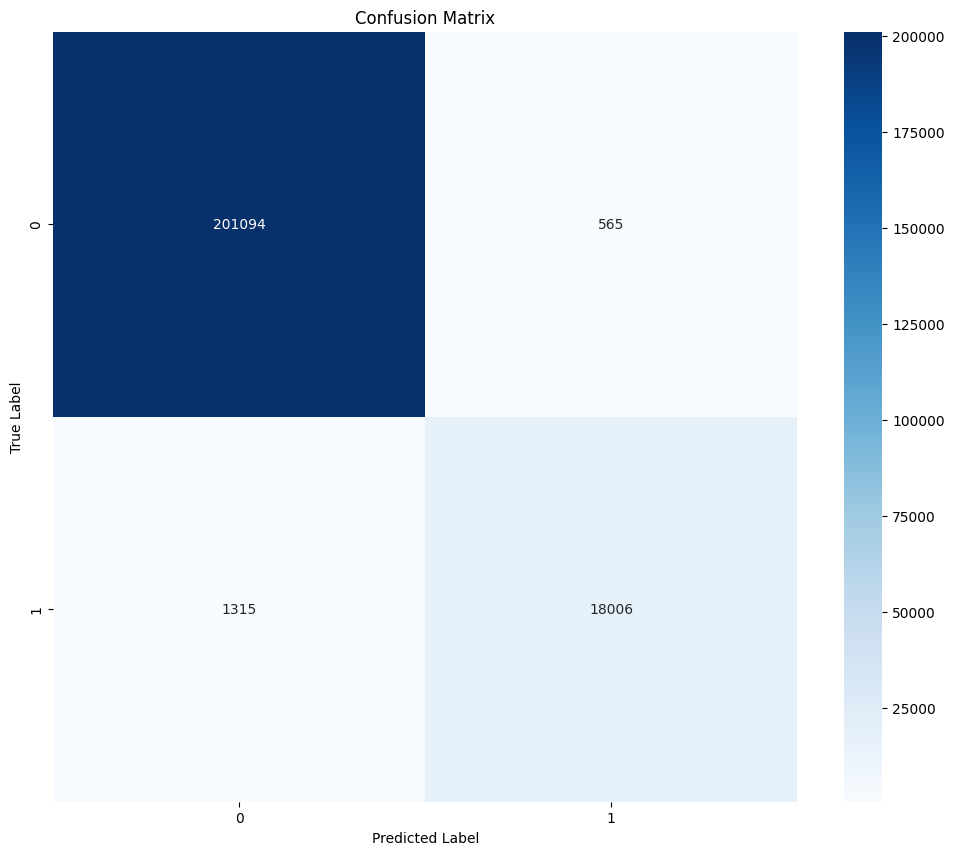

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_actual)

print(set(y_test))
# Plot confusion matrix
labels = list(set(y_test))
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()